# EDA

# Prepare data - Jan 2015

In [1]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import contextily as ctx

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Connect to the database
con =  psycopg2.connect(dbname='carto', user='carto', password='carto', host='postgis', port='5432')

In [3]:
# Query to select only 10,000 pickup data from January
q_jan = '''
            SELECT tpep_pickup_datetime as pickup_time, pickup_point
            FROM taxi_geom
            WHERE tpep_pickup_datetime > '2014-12-31' AND tpep_pickup_datetime <'2015-03-01'
            LIMIT 10000;
        '''

# Save the query result as a geodataframe
pickup_jan = gpd.read_postgis(q_jan, con, geom_col='pickup_point')
pickup_jan.head()

,pickup_time,pickup_point
0,2015-01-01 01:57:49,POINT (-73.97600 40.75119)
1,2015-01-01 01:57:49,POINT (-73.95277 40.77673)
2,2015-01-01 01:57:49,POINT (-73.97182 40.75723)
3,2015-01-01 01:57:49,POINT (-74.00397 40.70764)
4,2015-01-01 01:57:50,POINT (-73.98099 40.74469)


In [4]:
if con:
    con.close()

In [5]:
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   10000 non-null  datetime64[ns]
 1   pickup_point  10000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 156.4 KB


In [6]:
# Remove missing values if exist
pickup_jan = pickup_jan[~pickup_jan.isnull()]
pickup_jan.shape

(10000, 2)

In [7]:
# Remove duplicated rows
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(10000, 2)

In [8]:
print(pickup_jan.crs)

epsg:4326


# More data

* demographic & socio-economic data
* census block group geometries

In [9]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(demographic.shape)
demographic.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [10]:
# NYC census block group geometries
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')
print(census.crs)
census.head()

epsg:4326


,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [11]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     6339 non-null   object  
 1   geometry  6339 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 99.2+ KB


In [12]:
# Change the data type of 'geoid' column
census.geoid = pd.to_numeric(census.geoid)
census.geoid.dtype

dtype('int64')

In [13]:
# Reproject data in Web mercator
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)

In [14]:
# Select pickup points only within the census block
blocks_union = census.geometry.unary_union
pickups_within_blocks = pickup_jan[pickup_jan.within(blocks_union)]

print(pickups_within_blocks.shape)
pickups_within_blocks.head()

(9981, 2)


,pickup_time,pickup_point
0,2015-01-01 01:57:49,POINT (-8234970.420 4975710.692)
1,2015-01-01 01:57:49,POINT (-8232384.300 4979464.898)
2,2015-01-01 01:57:49,POINT (-8234505.003 4976599.214)
3,2015-01-01 01:57:49,POINT (-8238083.955 4969313.477)
4,2015-01-01 01:57:50,POINT (-8235525.862 4974756.672)


# Visualize the data

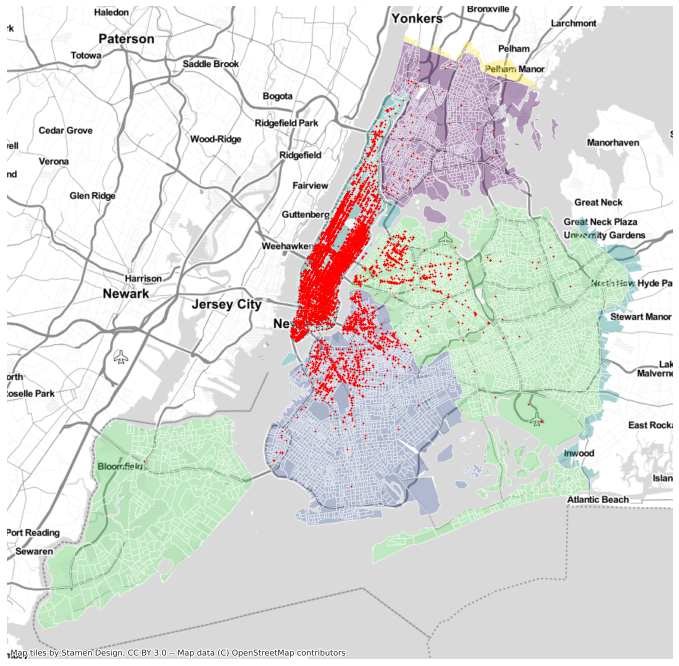

In [15]:
# Plot the census blocks
ax = census.plot(column = 'geoid', figsize=(12, 12), scheme='EqualInterval', alpha=.4, cmap='viridis')

# pickup points within blocks (red points)
pickups_within_blocks.plot(ax=ax, color='red', markersize=.6)

# basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.show()

# simpe EDA to understand the data

In [38]:
# Spatial join
pickup_blocks = gpd.sjoin(census, pickups_within_blocks, how='inner', op='intersects')
pickup_blocks.head()

,geoid,geometry,index_right,pickup_time
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",4123,2015-01-01 02:06:28
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",2843,2015-01-01 02:03:45
22,360050023001,"POLYGON ((-8229763.014 4984292.847, -8229689.2...",5222,2015-01-01 02:08:46
41,360050031001,"POLYGON ((-8227450.240 4983838.835, -8227382.3...",5684,2015-01-01 02:09:44
50,360050039001,"POLYGON ((-8228650.376 4983997.817, -8228456.1...",386,2015-01-01 01:58:40


<AxesSubplot:>

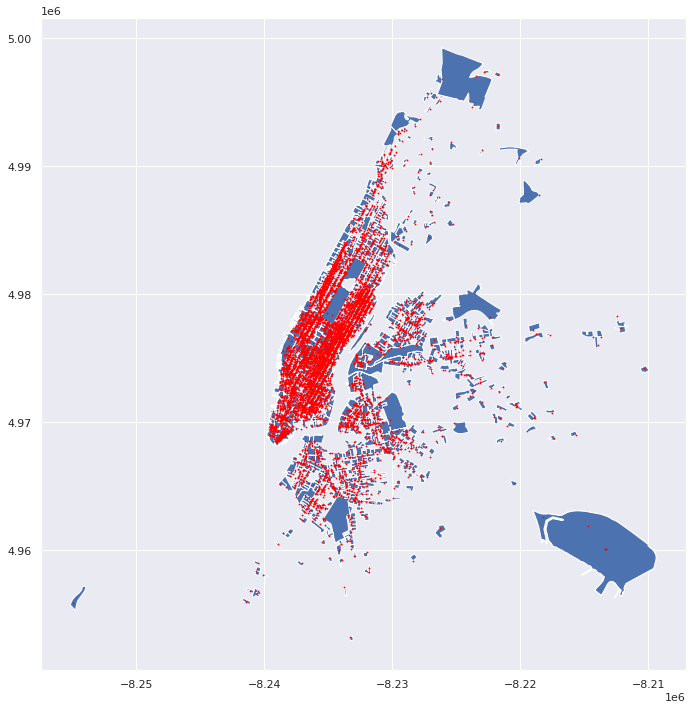

In [39]:
# Plot the new dataframe
ax = pickup_blocks.plot(figsize=(12,12))

# pickup points within blocks (red points)
pickups_within_blocks.plot(ax=ax, color='red', markersize=.6)

In [45]:
# Count how many pickups were made within each block
pickup_blocks.groupby('geoid').pickup_time.count().sort_values()

geoid
360850303012      1
360610277003      1
360470497001      1
360470495003      1
360610279004      1
               ... 
360610135001     62
360610099001     72
360610143001     76
360610092001    140
360610101001    162
Name: pickup_time, Length: 1650, dtype: int64

# Task: 
Merge the taxi and ACS dataset by block group and compute the average number of pickups by block group 